# Example Notebook for Model Training
All code required to train a model is included in this notebook. A class for parsing the sample data is provided in the ```parser.py``` file

In [1]:
from qml.representations import generate_coulomb_matrix as cm_qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge

from parser import Parser

## Helper Functions

In [25]:
def get_shuffled_indices(num_examples):
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    return indices

def expmae(y_true, y_pred):
    return mae(np.exp(y_true), np.exp(y_pred))

def custom_learning_curve(training_sizes, grid, cv, 
                          reprs, targets, train_val_idx, test_idx):
    estimator = KernelRidge(kernel='rbf')
    scorers = {'neg_mean': 'neg_mean_absolute_error', 'r2' : 'r2'}
    
    gs = GridSearchCV(estimator, grid, scoring = scorers,
                      refit = 'neg_mean', cv = cv,
                      error_score = 'raise',
                      return_train_score = False, verbose = 1)
    best_param = []
    error = []
    predictions = []
    best_estimators = []

    test_reprs = reprs[test_idx]
    test_targets = targets[test_idx]
    
    for size in training_sizes:
        print(f"Training on {size} examples...")
        train_idx = train_val_idx[:size]
        gs.fit(reprs[train_idx], targets[train_idx])
        best_param.append(gs.best_params_)
        print(f"Best parameters from Grid Search: {best_param[-1]}")
        print(f"Prediction on {len(test_idx)} examples...")
        pred = (gs.predict(test_reprs))
        predictions.append(pred)
        error.append(mae(test_targets, pred))
        r2_score = r2(test_targets, pred)
        print(f"best r2 score for {size} examples: {r2_score}, best MAE: {error[-1]}")
        best_estimators.append(gs.best_estimator_)
    return best_param, predictions, error, best_estimators

## Read in Data
Parser from ```parser.py``` reads data from files (MD snapshots of anthracene 5x5x5 cube) provided with the supporting information. Ignore if using own data.

In [49]:
parser = Parser(nonzero_only = True) 
# entries where coupling == 0 are outside of the cutoff

num_fragments = 75
atoms_per_frag = 24

in_path =  "./data/7_5A"

data = parser.parse(in_path, atoms_per_frag, num_fragments,
                    cutoff = None, step_increment = 10)
pair_nuc_chg, pair_coords, couplings, frag_nuc_chg, frag_coords, energies = data

Train on absolute values of the couplings:

In [48]:
targets = np.abs(couplings)

## Generate Representations

In [36]:
cm_size = 2*atoms_per_frag
reprs = np.array([cm_qml(pair_nuc_chg, pair, size = cm_size, sorting = 'unsorted') for pair in pair_coords])

## Set Training Hyperparameters and other Preparations

In [37]:
cv_folds = 2
train_sizes = [100, 1000, 5000, 10000]
l_reg = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
sigmas = [5, 10, 15, 20]
# sklearn uses different naming convention for KRR hyperparameters.
grid = {"alpha" : l_reg, "gamma" : 1/(2*np.asarray(sigmas)**2)}

shuffled_idx = get_shuffled_indices(reprs.shape[0])
train_val_idx = shuffled_idx[:max(train_sizes)]
test_idx = shuffled_idx[max(train_sizes):]

## Calculate Learning Curve with Grid Search for every Training Size

In [38]:
best_param, predictions, errors, best_models = custom_learning_curve(train_sizes, grid, cv_folds,
                                                                     reprs, targets, train_val_idx, test_idx)


Training on 100 examples...
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters from Grid Search: {'alpha': 0.01, 'gamma': 0.0022222222222222222}
Prediction on 75075 examples...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


best r2 score for 100 examples: 0.4772835165347299, best MAE: 0.010807977959512603
Training on 1000 examples...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.9s finished


Best parameters from Grid Search: {'alpha': 0.01, 'gamma': 0.005}
Prediction on 75075 examples...
best r2 score for 1000 examples: 0.8348777977981232, best MAE: 0.00597674141979663
Training on 5000 examples...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   17.1s finished


Best parameters from Grid Search: {'alpha': 0.01, 'gamma': 0.005}
Prediction on 75075 examples...
best r2 score for 5000 examples: 0.91544904262978, best MAE: 0.004074078964231667
Training on 10000 examples...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min finished


Best parameters from Grid Search: {'alpha': 0.01, 'gamma': 0.005}
Prediction on 75075 examples...
best r2 score for 10000 examples: 0.9324724317917172, best MAE: 0.0036412027653106847


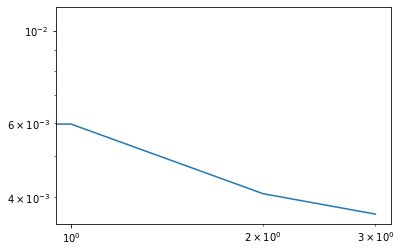

In [39]:
plt.loglog(errors)